In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("/kaggle/src")

In [3]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold


NUM_BOOST_ROUND = 5000
STOPPING_ROUNDS = 20
VERBOSE_EVAL = 30


def quadratic_weighted_kappa(preds, data):
    y_true = data.get_label()
    y_pred = preds.clip(0, 3).round().astype(int)
    qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
    return "QWK", qwk, True


def threshold_rounder(oof_preds, thresholds):
    labels = []
    for value in oof_preds:
        if value < thresholds[0]:
            labels.append(0)
        elif value < thresholds[1]:
            labels.append(1)
        elif value < thresholds[2]:
            labels.append(2)
        else:
            labels.append(3)
    return np.array(labels)


def evaluate_predictions(thresholds, y_true, oof_preds):
    oof_preds_rounded = threshold_rounder(oof_preds, thresholds)
    return -cohen_kappa_score(y_true, oof_preds_rounded, weights="quadratic")


def train_kfold(features, targets, categorical_features, n_splits, model_params, weights=None):
    if weights is None:
        weights = np.ones(len(features))
    skf = StratifiedKFold(
        n_splits=n_splits, shuffle=True, random_state=1
    )
    boosters = []
    val_qwks = []
    oof_preds = np.zeros(len(features))

    for trn_idx, val_idx in skf.split(features, targets):
        trn_data = lgb.Dataset(
            data=features.iloc[trn_idx],
            label=targets.iloc[trn_idx],
            weight=weights[trn_idx],
            categorical_feature=categorical_features,
        )
        val_data = lgb.Dataset(
            data=features.iloc[val_idx],
            label=targets.iloc[val_idx],
            weight=weights[val_idx],
            reference=trn_data,
        )
        eval_result = {}
        callbacks = [
            lgb.early_stopping(STOPPING_ROUNDS),
            lgb.log_evaluation(VERBOSE_EVAL),
            lgb.record_evaluation(eval_result),
        ]
        booster = lgb.train(
            model_params,
            trn_data,
            valid_sets=[trn_data, val_data],
            valid_names=["trn", "val"],
            num_boost_round=NUM_BOOST_ROUND,
            feval=quadratic_weighted_kappa,
            callbacks=callbacks,
        )
        boosters.append(booster)
        val_qwks.append(
            eval_result["val"]["QWK"][booster.best_iteration - 1]
        )
        oof_preds[val_idx] = booster.predict(features.iloc[val_idx])
    print(f"Avg. Kappa: {np.mean(val_qwks):.4f}")
    return boosters, eval_result, val_qwks, oof_preds


def run_kfold(
        features, trn_targets, categorical_features, n_splits, model_params,
        weights=None, trn_id=None, tst_id=None
):
    trn_features = features.iloc[:len(trn_targets)]
    tst_features = features.iloc[len(trn_targets):]
    boosters, eval_result, qwks, oof_preds = train_kfold(
        trn_features, trn_targets, categorical_features, n_splits, model_params, weights
    )
    # save_loss
    loss = pd.DataFrame(
        data={
            "trn_rmse": eval_result["trn"]["rmse"],
            "val_rmse": eval_result["val"]["rmse"],
            "trn_qwk": eval_result["trn"]["QWK"],
            "val_qwk": eval_result["val"]["QWK"]
        }
    )
    print(loss)
    # kappa_optimizer
    kappa_optimizer = minimize(
        evaluate_predictions,
        x0=[0.5, 1.5, 2.5],
        args=(trn_targets.to_numpy(), oof_preds),
        method="Nelder-Mead",
    )
    # oof_preds
    oof_preds = threshold_rounder(oof_preds, kappa_optimizer.x)
    qwk_optimized = cohen_kappa_score(trn_targets.to_numpy(), oof_preds, weights="quadratic")
    print(f"Optimized Kappa: {qwk_optimized:.4f}")
    oof_preds = pd.DataFrame(
        data={"id": trn_id, "sii": oof_preds}
    )
    # tst_preds
    tst_preds = np.zeros(len(tst_features))
    for i, booster in enumerate(boosters):
        tst_preds += booster.predict(tst_features) / n_splits
    tst_preds = threshold_rounder(tst_preds, kappa_optimizer.x)
    tst_preds = pd.DataFrame(
        data={"id": tst_id, "sii": tst_preds}
    )
    tst_preds.to_csv("/kaggle/working/submission.csv", index=False)

In [4]:
# Import
import sys
sys.path.append("/kaggle/src")  # Change on kaggle notebook

from pathlib import Path

import polars as pl
from sklearn.preprocessing import LabelEncoder

from common.constant import TRAIN_CSV_PATH, TEST_CSV_PATH, OUTPUT_DIR
# from preprocess.table import fill_missing
# from run.lgb001 import run_kfold

# Data
trn_df = pl.read_csv(TRAIN_CSV_PATH)
tst_df = pl.read_csv(TEST_CSV_PATH)

base_cols = [col for col in trn_df.columns if col in tst_df.columns]
df = pl.concat([trn_df[base_cols], tst_df])

# Preprocessing
# df = fill_missing(df)

# Feature engineering
features = pl.concat(
    [
        df,
    ],
    how="horizontal",
)

trn_id = trn_df.drop_nulls(subset=["sii"])["id"].to_list()
tst_id = tst_df["id"].to_list()
features = pl.concat([
    features.slice(0, len(trn_df)).filter(pl.col("id").is_in(trn_id)),
    features.slice(len(trn_df)).filter(pl.col("id").is_in(tst_id))
])

# Label encoding
cat_cols = features.select(pl.col(pl.Utf8)).columns
cat_cols.remove("id")
le = LabelEncoder()
for col in cat_cols:
    encoded = le.fit_transform(features[col].to_numpy())
    features = features.with_columns(pl.Series(encoded).alias(col))

# Model parameters
model_params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting": "gbdt",
    "num_leaves": 64,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "feature_fraction": 0.8,
    "learning_rate": 0.1,
    "seed": 1,
    "num_threads": 4,
}



In [39]:
run_kfold(
    features=features.drop("id").to_pandas(),
    trn_targets=trn_df.filter(pl.col("id").is_in(trn_id))["sii"].to_pandas(),
    categorical_features=cat_cols,
    n_splits=10,
    model_params=model_params,
    weights=None,
    trn_id=trn_id,
    tst_id=tst_id,
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5987
[LightGBM] [Info] Number of data points in the train set: 2462, number of used features: 58
[LightGBM] [Info] Start training from score 0.580829
Training until validation scores don't improve for 20 rounds
[30]	trn's rmse: 0.429619	trn's QWK: 0.75525	val's rmse: 0.715368	val's QWK: 0.269592
Early stopping, best iteration is:
[14]	trn's rmse: 0.546517	trn's QWK: 0.594476	val's rmse: 0.699677	val's QWK: 0.311908
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5993
[LightGBM] [Info] Number of data points in the train set: 2462, number of used features: 58
[LightGBM] [Info] Start training from score 0.580829
Training until validation scores don't improve fo

In [5]:
import optuna

In [6]:
base_params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting": "gbdt",
    "learning_rate": 0.01,
    "seed": 1,
    "num_threads": 4,
}

In [17]:
def train_kfold(features, targets, categorical_features, n_splits, base_params, weights=None):
    if weights is None:
        weights = np.ones(len(features))

    skf = StratifiedKFold(
        n_splits=n_splits, shuffle=True, random_state=1
    )
    boosters = []
    val_qwks = []
    oof_preds = np.zeros(len(features))

    for i, (trn_idx, val_idx) in enumerate(skf.split(features, targets)):
        trn_data = lgb.Dataset(
            data=features.iloc[trn_idx],
            label=targets.iloc[trn_idx],
            weight=weights[trn_idx],
            categorical_feature=categorical_features,
            free_raw_data=False
        )
        val_data = lgb.Dataset(
            data=features.iloc[val_idx],
            label=targets.iloc[val_idx],
            weight=weights[val_idx],
            categorical_feature=categorical_features,
            free_raw_data=False
        )

        if i == 0:          
            def objective(trial):
                params = {
                    # "learning_rate": trial.suggest_float("learning_rate", 0.01, 1.0),
                    "num_leaves": trial.suggest_int("num_leaves", 2, 256),
                    "max_depth": trial.suggest_int("max_depth", 1, 16),
                    "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 0, 300),
                    "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 1.0),
                    "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
                    "feature_fraction": trial.suggest_uniform("feature_fraction", 0.4, 1.0),
                    "min_child_samples": trial.suggest_int("min_child_sample", 5, 100),
                    "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
                    "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
                }
                eval_result = {}
                callbacks = [
                    lgb.early_stopping(STOPPING_ROUNDS),
                    # lgb.log_evaluation(VERBOSE_EVAL),
                    lgb.record_evaluation(eval_result),
                ]
                booster = lgb.train(
                    {**base_params, **params},
                    trn_data,
                    valid_sets=[trn_data, val_data],
                    valid_names=["trn", "val"],
                    num_boost_round=NUM_BOOST_ROUND,
                    callbacks=callbacks
                )
                return eval_result["val"]["rmse"][booster.best_iteration - 1]
            
            study = optuna.create_study(direction="minimize")
            study.optimize(objective, n_trials=100)
            best_params = study.best_params
            best_loss = study.best_value
            print("Best hyperparameters:", best_params)
            print("Best Loss:", best_loss)
        break   

In [8]:
features=features.drop("id").to_pandas()
trn_targets=trn_df.filter(pl.col("id").is_in(trn_id))["sii"].to_pandas()
trn_features = features.iloc[:len(trn_targets)]
tst_features = features.iloc[len(trn_targets):]

In [18]:
train_kfold(trn_features, trn_targets, categorical_features=cat_cols, n_splits=5, base_params=base_params)

[I 2024-10-27 21:27:07,769] A new study created in memory with name: no-name-74b4efd1-b076-4e83-b5b2-424e0473acb4
/tmp/ipykernel_390638/643600196.py:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 1.0),
/tmp/ipykernel_390638/643600196.py:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "feature_fraction": trial.suggest_uniform("feature_fraction", 0.4, 1.0),
/tmp/ipykernel_390638/643600196.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lambda_l1": trial.suggest_loguniform(

[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=47 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=47 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5928
[LightGBM] [Info] Number of data points in the train set: 2188, number of used features: 58
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=47 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Info] Start training from score 0.579982
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

[I 2024-10-27 21:27:07,986] Trial 1 finished with value: 0.6897554961878478 and parameters: {'num_leaves': 157, 'max_depth': 16, 'min_data_in_leaf': 171, 'bagging_fraction': 0.518254396949788, 'bagging_freq': 3, 'feature_fraction': 0.4376575663502093, 'min_child_sample': 49, 'lambda_l1': 4.182258497249038e-08, 'lambda_l2': 5.292711613203771e-08}. Best is trial 0 with value: 0.686093592307951.
[I 2024-10-27 21:27:08,070] Trial 2 finished with value: 0.6867137336256727 and parameters: {'num_leaves': 244, 'max_depth': 6, 'min_data_in_leaf': 133, 'bagging_fraction': 0.48531184859637566, 'bagging_freq': 7, 'feature_fraction': 0.41690189149731904, 'min_child_sample': 30, 'lambda_l1': 0.0005055790453529791, 'lambda_l2': 2.2283910029189652e-05}. Best is trial 0 with value: 0.686093592307951.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:08,223] Trial 3 finished with value: 0.6851443535799473 and parameters: {'num_leaves': 28, 'max_depth': 7, 'min_data_in_leaf': 240, 'bagging_fraction': 0.953021137183555, 'bagging_freq': 1, 'feature_fraction': 0.7454133921773181, 'min_child_sample': 85, 'lambda_l1': 7.020330891098437e-08, 'lambda_l2': 0.6249356332870412}. Best is trial 3 with value: 0.6851443535799473.
[I 2024-10-27 21:27:08,348] Trial 4 finished with value: 0.6825575741292037 and parameters: {'num_leaves': 117, 'max_depth': 13, 'min_data_in_leaf': 108, 'bagging_fraction': 0.8352529281032017, 'bagging_freq': 3, 'feature_fraction': 0.569625812459081, 'min_child_sample': 75, 'lambda_l1': 1.5970900400918077e-08, 'lambda_l2': 0.007610766621601987}. Best is trial 4 with value: 0.6825575741292037.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:08,503] Trial 5 finished with value: 0.6844319552616817 and parameters: {'num_leaves': 241, 'max_depth': 16, 'min_data_in_leaf': 202, 'bagging_fraction': 0.7813505529296587, 'bagging_freq': 1, 'feature_fraction': 0.7660270006260674, 'min_child_sample': 82, 'lambda_l1': 0.002913237457620672, 'lambda_l2': 0.00089617669735841}. Best is trial 4 with value: 0.6825575741292037.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:08,638] Trial 6 finished with value: 0.6838367083746675 and parameters: {'num_leaves': 166, 'max_depth': 14, 'min_data_in_leaf': 241, 'bagging_fraction': 0.9462980763117587, 'bagging_freq': 2, 'feature_fraction': 0.5478752222774436, 'min_child_sample': 8, 'lambda_l1': 1.2524980510115172e-07, 'lambda_l2': 0.001960423811027547}. Best is trial 4 with value: 0.6825575741292037.
[I 2024-10-27 21:27:08,724] Trial 7 finished with value: 0.6884591020211193 and parameters: {'num_leaves': 70, 'max_depth': 16, 'min_data_in_leaf': 189, 'bagging_fraction': 0.5687118690424375, 'bagging_freq': 7, 'feature_fraction': 0.40510706566796345, 'min_child_sample': 84, 'lambda_l1': 7.956117810883218, 'lambda_l2': 7.601068799739465e-06}. Best is trial 4 with value: 0.6825575741292037.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Reducing `min_data_in_leaf` with `feature_pre_filter=true` may cause unexpected behaviour for features that were pre-filtered by the larger `min_data_in_leaf`.
You need to set `feature_pre_filter=false` to dynamically change the `min_data_in_leaf`.
[LightGBM] [Fatal] Reducing `min_data_in_leaf` with `feature_pre_filter=true` may cause unexpected behaviour for features that were pre-filtered by the larger `min_data_in_leaf`.
You need to set `feature_pre_filter=false` to dynamically change the `min_data_in_leaf`.
[I 2024-10-27 21:27:08,871] Trial 8 finished with value: 0.686322020868932 and parameters: {'num_leaves': 196, 'max_depth': 4, 'min_data_in_leaf': 2, 'bagging_fraction': 0.8064260040987069, 'bagging_freq': 2, 'feature_fraction': 0.5997388003199946, 'min_child_sample': 94, 'lambda_l1': 1.2420616449632077e-08, 'lambda_l2': 0.00028161745474462093}. Best is trial 4 with value: 0.6825575741292037.
/tmp/ipykernel_390638/643600196.py:35: FutureWarning: suggest_unifor

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:09,016] Trial 9 finished with value: 0.6826619201651675 and parameters: {'num_leaves': 209, 'max_depth': 10, 'min_data_in_leaf': 174, 'bagging_fraction': 0.9708988727492384, 'bagging_freq': 6, 'feature_fraction': 0.4675550694458707, 'min_child_sample': 72, 'lambda_l1': 0.0002303889162294068, 'lambda_l2': 2.0737170249647057}. Best is trial 4 with value: 0.6825575741292037.
[I 2024-10-27 21:27:09,162] Trial 10 finished with value: 0.6837194768972544 and parameters: {'num_leaves': 110, 'max_depth': 10, 'min_data_in_leaf': 65, 'bagging_fraction': 0.6577724113200004, 'bagging_freq': 5, 'feature_fraction': 0.6432326185630344, 'min_child_sample': 63, 'lambda_l1': 6.081066417236367e-06, 'lambda_l2': 0.012006832880339}. Best is trial 4 with value: 0.6825575741292037.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:09,330] Trial 11 finished with value: 0.6836902209083636 and parameters: {'num_leaves': 109, 'max_depth': 11, 'min_data_in_leaf': 119, 'bagging_fraction': 0.8673505547599442, 'bagging_freq': 5, 'feature_fraction': 0.5180643260269827, 'min_child_sample': 68, 'lambda_l1': 0.07247113997091029, 'lambda_l2': 3.6746979446731176}. Best is trial 4 with value: 0.6825575741292037.


[LightGBM] [Warning] min_data_in_leaf is set=119, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=119
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=119, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=119
[LightGBM] [Warning] min_data_in_leaf is set=119, min_child_samples=68 will be ignored. Current value: min_data_in_leaf=119
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5928
[LightGBM] [Info] Number of data points in the train set: 2188, number of used features: 58
[LightGBM] [Info] Start training from score 0.579982
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further

[I 2024-10-27 21:27:09,443] Trial 12 finished with value: 0.6948026919588375 and parameters: {'num_leaves': 76, 'max_depth': 1, 'min_data_in_leaf': 289, 'bagging_fraction': 0.9908728173827154, 'bagging_freq': 5, 'feature_fraction': 0.5166930265586126, 'min_child_sample': 68, 'lambda_l1': 1.1993810308342117e-05, 'lambda_l2': 0.05604466718118147}. Best is trial 4 with value: 0.6825575741292037.


Early stopping, best iteration is:
[635]	trn's rmse: 0.667687	val's rmse: 0.694803
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=59 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=59 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=59 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5928
[LightGBM] [Info] Number of data points in the train set: 2188, number of used features: 58
[LightGBM] [Info] Start

[I 2024-10-27 21:27:09,653] Trial 13 finished with value: 0.6870411320057457 and parameters: {'num_leaves': 140, 'max_depth': 12, 'min_data_in_leaf': 58, 'bagging_fraction': 0.8584086691770446, 'bagging_freq': 4, 'feature_fraction': 0.6746412240616666, 'min_child_sample': 59, 'lambda_l1': 4.502487435347845e-06, 'lambda_l2': 0.07422508301076033}. Best is trial 4 with value: 0.6825575741292037.
[I 2024-10-27 21:27:09,797] Trial 14 finished with value: 0.6851748559444881 and parameters: {'num_leaves': 214, 'max_depth': 9, 'min_data_in_leaf': 145, 'bagging_fraction': 0.7121984866057066, 'bagging_freq': 6, 'feature_fraction': 0.9987005793942466, 'min_child_sample': 36, 'lambda_l1': 0.017092047937083868, 'lambda_l2': 2.1736698775866454}. Best is trial 4 with value: 0.6825575741292037.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iter

[I 2024-10-27 21:27:09,956] Trial 15 finished with value: 0.6829201946149239 and parameters: {'num_leaves': 71, 'max_depth': 13, 'min_data_in_leaf': 108, 'bagging_fraction': 0.8708158904299589, 'bagging_freq': 4, 'feature_fraction': 0.5832382962528389, 'min_child_sample': 100, 'lambda_l1': 4.7665657591612285e-05, 'lambda_l2': 9.294540610306713}. Best is trial 4 with value: 0.6825575741292037.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:10,143] Trial 16 finished with value: 0.688324476771868 and parameters: {'num_leaves': 23, 'max_depth': 8, 'min_data_in_leaf': 19, 'bagging_fraction': 0.7354359589389838, 'bagging_freq': 3, 'feature_fraction': 0.4636254792841005, 'min_child_sample': 76, 'lambda_l1': 1.0627378877925525e-06, 'lambda_l2': 4.564286693085844e-05}. Best is trial 4 with value: 0.6825575741292037.
[I 2024-10-27 21:27:10,313] Trial 17 finished with value: 0.684690107064251 and parameters: {'num_leaves': 120, 'max_depth': 14, 'min_data_in_leaf': 211, 'bagging_fraction': 0.9411550983623006, 'bagging_freq': 6, 'feature_fraction': 0.8248417748791872, 'min_child_sample': 75, 'lambda_l1': 0.00019274614930596312, 'lambda_l2': 6.629605595082147e-07}. Best is trial 4 with value: 0.6825575741292037.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[251]	trn's rmse: 0.554447	val's rmse: 0.688324
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=211, min_child_samples=75 will be ignored. Current value: min_data_in_leaf=211
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=211, min_child_samples=75 will be ignored. Current value: min_data_in_leaf=211
[LightGBM] [Warning] min_data_in_leaf is set=211, min_child_samples=75 will be ignored. Current value: min_data_in_leaf=211
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000664 seconds.
You can set `force_col_wise=true` to remove the ove

[I 2024-10-27 21:27:10,406] Trial 18 finished with value: 0.6907015481578374 and parameters: {'num_leaves': 213, 'max_depth': 12, 'min_data_in_leaf': 160, 'bagging_fraction': 0.4136045868796205, 'bagging_freq': 3, 'feature_fraction': 0.48502534360285277, 'min_child_sample': 38, 'lambda_l1': 0.10664548915326463, 'lambda_l2': 0.010540173580662256}. Best is trial 4 with value: 0.6825575741292037.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=160, min_child_samples=38 will be ignored. Current value: min_data_in_leaf=160
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=160, min_child_samples=38 will be ignored. Current value: min_data_in_leaf=160
[LightGBM] [Warning] min_data_in_leaf is set=160, min_child_samples=38 will be ignored. Current value: min_data_in_leaf=160
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5928
[LightGBM] [Info] Number of data points in the train set: 2188, number of used features: 58
[LightGBM] [Info] Start training from score 0.579982
[LightGBM] [Warning] No further splits with pos

[I 2024-10-27 21:27:10,555] Trial 19 finished with value: 0.6855506078984891 and parameters: {'num_leaves': 145, 'max_depth': 10, 'min_data_in_leaf': 87, 'bagging_fraction': 0.6355315626700703, 'bagging_freq': 6, 'feature_fraction': 0.5970056475322982, 'min_child_sample': 19, 'lambda_l1': 6.039735185728412e-07, 'lambda_l2': 0.040967156851105774}. Best is trial 4 with value: 0.6825575741292037.
[I 2024-10-27 21:27:10,722] Trial 20 finished with value: 0.6843346387298641 and parameters: {'num_leaves': 91, 'max_depth': 3, 'min_data_in_leaf': 40, 'bagging_fraction': 0.8937050372066061, 'bagging_freq': 4, 'feature_fraction': 0.7116490645349098, 'min_child_sample': 55, 'lambda_l1': 0.0018533056542944595, 'lambda_l2': 0.2391739398981363}. Best is trial 4 with value: 0.6825575741292037.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:10,875] Trial 21 finished with value: 0.6838909956875215 and parameters: {'num_leaves': 56, 'max_depth': 13, 'min_data_in_leaf': 99, 'bagging_fraction': 0.8143779683779878, 'bagging_freq': 4, 'feature_fraction': 0.5703654971606712, 'min_child_sample': 100, 'lambda_l1': 0.00011668539539649922, 'lambda_l2': 9.991611641799556}. Best is trial 4 with value: 0.6825575741292037.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5928
[LightGBM] [Info] Number of data points in the train set: 2188, number of used features: 58
[LightGBM] [Info] Start training from score 0.579982
[LightGBM] [Warning] No further splits with positi

[I 2024-10-27 21:27:11,014] Trial 22 finished with value: 0.689068467461662 and parameters: {'num_leaves': 2, 'max_depth': 14, 'min_data_in_leaf': 119, 'bagging_fraction': 0.9106729653115249, 'bagging_freq': 4, 'feature_fraction': 0.6222359068206031, 'min_child_sample': 92, 'lambda_l1': 3.496799800023008e-05, 'lambda_l2': 8.522669442812912}. Best is trial 4 with value: 0.6825575741292037.
[I 2024-10-27 21:27:11,166] Trial 23 finished with value: 0.6833433847257562 and parameters: {'num_leaves': 86, 'max_depth': 12, 'min_data_in_leaf': 168, 'bagging_fraction': 0.9951766176378584, 'bagging_freq': 3, 'feature_fraction': 0.5021037496781864, 'min_child_sample': 74, 'lambda_l1': 3.8347187994755947e-07, 'lambda_l2': 1.1319636195331464}. Best is trial 4 with value: 0.6825575741292037.


Early stopping, best iteration is:
[772]	trn's rmse: 0.660177	val's rmse: 0.689068
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=168, min_child_samples=74 will be ignored. Current value: min_data_in_leaf=168
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=168, min_child_samples=74 will be ignored. Current value: min_data_in_leaf=168
[LightGBM] [Warning] min_data_in_leaf is set=168, min_child_samples=74 will be ignored. Current value: min_data_in_leaf=168
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5928
[LightGBM] [Info] Number of data points in the train set: 2188, number of used features: 58
[LightGBM] [Info]

[I 2024-10-27 21:27:11,333] Trial 24 finished with value: 0.6832417790490264 and parameters: {'num_leaves': 44, 'max_depth': 10, 'min_data_in_leaf': 114, 'bagging_fraction': 0.8521019989324776, 'bagging_freq': 5, 'feature_fraction': 0.5421980508905095, 'min_child_sample': 93, 'lambda_l1': 0.6038966560784351, 'lambda_l2': 0.006883791659033821}. Best is trial 4 with value: 0.6825575741292037.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:11,535] Trial 25 finished with value: 0.6845102222120262 and parameters: {'num_leaves': 100, 'max_depth': 13, 'min_data_in_leaf': 68, 'bagging_fraction': 0.7629254196375518, 'bagging_freq': 3, 'feature_fraction': 0.6497462022157181, 'min_child_sample': 100, 'lambda_l1': 6.426471008226264e-05, 'lambda_l2': 0.16665236763793892}. Best is trial 4 with value: 0.6825575741292037.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:11,672] Trial 26 finished with value: 0.68496959572862 and parameters: {'num_leaves': 129, 'max_depth': 8, 'min_data_in_leaf': 226, 'bagging_fraction': 0.8275301899870684, 'bagging_freq': 4, 'feature_fraction': 0.45463091340152506, 'min_child_sample': 65, 'lambda_l1': 0.000864525914028904, 'lambda_l2': 1.4794762395942258}. Best is trial 4 with value: 0.6825575741292037.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:11,828] Trial 27 finished with value: 0.6825375775813002 and parameters: {'num_leaves': 172, 'max_depth': 15, 'min_data_in_leaf': 145, 'bagging_fraction': 0.9129443600520224, 'bagging_freq': 6, 'feature_fraction': 0.5760425399823788, 'min_child_sample': 81, 'lambda_l1': 0.010889927452642138, 'lambda_l2': 0.0010828425501434938}. Best is trial 27 with value: 0.6825375775813002.
[I 2024-10-27 21:27:11,996] Trial 28 finished with value: 0.6816299514727917 and parameters: {'num_leaves': 165, 'max_depth': 15, 'min_data_in_leaf': 142, 'bagging_fraction': 0.9118824951116682, 'bagging_freq': 7, 'feature_fraction': 0.7028873183067641, 'min_child_sample': 80, 'lambda_l1': 0.005615641691091732, 'lambda_l2': 0.0001988363483715657}. Best is trial 28 with value: 0.6816299514727917.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:12,166] Trial 29 finished with value: 0.684549713714715 and parameters: {'num_leaves': 185, 'max_depth': 15, 'min_data_in_leaf': 132, 'bagging_fraction': 0.9009585444711823, 'bagging_freq': 7, 'feature_fraction': 0.8124791759913638, 'min_child_sample': 84, 'lambda_l1': 0.006955774631603081, 'lambda_l2': 0.00016545511794186304}. Best is trial 28 with value: 0.6816299514727917.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=84 will be ignored. Current value: min_data_in_leaf=132
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=84 will be ignored. Current value: min_data_in_leaf=132
[LightGBM] [Warning] min_data_in_leaf is set=132, min_child_samples=84 will be ignored. Current value: min_data_in_leaf=132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5928
[LightGBM] [Info] Number of data points in the train set: 2188, number of used features: 58
[LightGBM] [Info] Start training from score 0.579982
[LightGBM] [Warning] No further splits with pos

[I 2024-10-27 21:27:12,356] Trial 30 finished with value: 0.6842093555861152 and parameters: {'num_leaves': 169, 'max_depth': 15, 'min_data_in_leaf': 83, 'bagging_fraction': 0.9173136636701075, 'bagging_freq': 7, 'feature_fraction': 0.7470034088217716, 'min_child_sample': 79, 'lambda_l1': 0.40094002271921253, 'lambda_l2': 1.5090082750942834e-06}. Best is trial 28 with value: 0.6816299514727917.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:12,542] Trial 31 finished with value: 0.6838449178751618 and parameters: {'num_leaves': 197, 'max_depth': 15, 'min_data_in_leaf': 143, 'bagging_fraction': 0.9721803632705003, 'bagging_freq': 6, 'feature_fraction': 0.6924028509078504, 'min_child_sample': 70, 'lambda_l1': 0.01864543398775706, 'lambda_l2': 0.0008420976207802515}. Best is trial 28 with value: 0.6816299514727917.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:12,721] Trial 32 finished with value: 0.6831902746721676 and parameters: {'num_leaves': 179, 'max_depth': 11, 'min_data_in_leaf': 177, 'bagging_fraction': 0.9246627431638802, 'bagging_freq': 6, 'feature_fraction': 0.5451350974261855, 'min_child_sample': 46, 'lambda_l1': 0.7538144671203105, 'lambda_l2': 8.901244898561076e-05}. Best is trial 28 with value: 0.6816299514727917.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:12,903] Trial 33 finished with value: 0.6830861438408992 and parameters: {'num_leaves': 221, 'max_depth': 16, 'min_data_in_leaf': 156, 'bagging_fraction': 0.968766753754823, 'bagging_freq': 7, 'feature_fraction': 0.6311900309392497, 'min_child_sample': 88, 'lambda_l1': 0.05566473851091579, 'lambda_l2': 1.1455366889820979e-08}. Best is trial 28 with value: 0.6816299514727917.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:13,039] Trial 34 finished with value: 0.6837775772820667 and parameters: {'num_leaves': 154, 'max_depth': 14, 'min_data_in_leaf': 188, 'bagging_fraction': 0.9999407245825733, 'bagging_freq': 6, 'feature_fraction': 0.4547512012000962, 'min_child_sample': 60, 'lambda_l1': 0.0005110590321966714, 'lambda_l2': 0.0022427162047248825}. Best is trial 28 with value: 0.6816299514727917.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:13,237] Trial 35 finished with value: 0.6840546182503541 and parameters: {'num_leaves': 230, 'max_depth': 6, 'min_data_in_leaf': 134, 'bagging_fraction': 0.8445967804486371, 'bagging_freq': 2, 'feature_fraction': 0.8124308726725731, 'min_child_sample': 72, 'lambda_l1': 0.006450852678252872, 'lambda_l2': 9.331660979167712e-06}. Best is trial 28 with value: 0.6816299514727917.
[I 2024-10-27 21:27:13,389] Trial 36 finished with value: 0.6840535193309037 and parameters: {'num_leaves': 251, 'max_depth': 15, 'min_data_in_leaf': 180, 'bagging_fraction': 0.7731259261746102, 'bagging_freq': 7, 'feature_fraction': 0.7087779869132619, 'min_child_sample': 79, 'lambda_l1': 2.0246709300506662, 'lambda_l2': 0.0004378430247775038}. Best is trial 28 with value: 0.6816299514727917.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[309]	trn's rmse: 0.621099	val's rmse: 0.684055
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=180, min_child_samples=79 will be ignored. Current value: min_data_in_leaf=180
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=180, min_child_samples=79 will be ignored. Current value: min_data_in_leaf=180
[LightGBM] [Warning] min_data_in_leaf is set=180, min_

[I 2024-10-27 21:27:13,546] Trial 37 finished with value: 0.6827995896133552 and parameters: {'num_leaves': 164, 'max_depth': 11, 'min_data_in_leaf': 204, 'bagging_fraction': 0.9551628956378709, 'bagging_freq': 5, 'feature_fraction': 0.4267350691514384, 'min_child_sample': 50, 'lambda_l1': 0.002604256656820771, 'lambda_l2': 0.0032099161060147453}. Best is trial 28 with value: 0.6816299514727917.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:13,677] Trial 38 finished with value: 0.6894253367746762 and parameters: {'num_leaves': 200, 'max_depth': 13, 'min_data_in_leaf': 260, 'bagging_fraction': 0.8918194048841946, 'bagging_freq': 7, 'feature_fraction': 0.8806480050078983, 'min_child_sample': 88, 'lambda_l1': 1.080551807771974e-08, 'lambda_l2': 2.1635274303677214e-05}. Best is trial 28 with value: 0.6816299514727917.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:13,859] Trial 39 finished with value: 0.6808455315610473 and parameters: {'num_leaves': 140, 'max_depth': 16, 'min_data_in_leaf': 97, 'bagging_fraction': 0.7972409502839582, 'bagging_freq': 6, 'feature_fraction': 0.667296788402341, 'min_child_sample': 55, 'lambda_l1': 0.17807343594937772, 'lambda_l2': 1.0113307906636787e-06}. Best is trial 39 with value: 0.6808455315610473.
[I 2024-10-27 21:27:14,024] Trial 40 finished with value: 0.6823546991838446 and parameters: {'num_leaves': 139, 'max_depth': 16, 'min_data_in_leaf': 95, 'bagging_fraction': 0.7947831376565478, 'bagging_freq': 1, 'feature_fraction': 0.6831664524682141, 'min_child_sample': 55, 'lambda_l1': 0.22060150366676934, 'lambda_l2': 3.254528541985542e-07}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:14,184] Trial 41 finished with value: 0.6851896897911766 and parameters: {'num_leaves': 139, 'max_depth': 16, 'min_data_in_leaf': 94, 'bagging_fraction': 0.7815455743669169, 'bagging_freq': 1, 'feature_fraction': 0.6596263902085447, 'min_child_sample': 43, 'lambda_l1': 0.18957688923803392, 'lambda_l2': 3.4799720731462586e-07}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=43 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=43 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=43 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5928
[LightGBM] [Info] Number of data points in the train set: 2188, number of used features: 58
[LightGBM] [Info] Start training from score 0.579982
[LightGBM] [Warning] No further splits with positive 

[I 2024-10-27 21:27:14,368] Trial 42 finished with value: 0.6828097263288011 and parameters: {'num_leaves': 125, 'max_depth': 16, 'min_data_in_leaf': 128, 'bagging_fraction': 0.7986718238498738, 'bagging_freq': 1, 'feature_fraction': 0.7361531905692019, 'min_child_sample': 55, 'lambda_l1': 0.028276605203142995, 'lambda_l2': 1.1126346803511711e-07}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:14,578] Trial 43 finished with value: 0.6828605310066057 and parameters: {'num_leaves': 151, 'max_depth': 15, 'min_data_in_leaf': 78, 'bagging_fraction': 0.7392749067866659, 'bagging_freq': 2, 'feature_fraction': 0.7710645722302625, 'min_child_sample': 27, 'lambda_l1': 9.864605636438034, 'lambda_l2': 2.0068797702358833e-06}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:14,793] Trial 44 finished with value: 0.6825033527169067 and parameters: {'num_leaves': 168, 'max_depth': 14, 'min_data_in_leaf': 105, 'bagging_fraction': 0.8248991717649065, 'bagging_freq': 2, 'feature_fraction': 0.6771870889389973, 'min_child_sample': 63, 'lambda_l1': 3.3501151141567056, 'lambda_l2': 1.6466384158938966e-08}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:14,966] Trial 45 finished with value: 0.6854639402360548 and parameters: {'num_leaves': 176, 'max_depth': 16, 'min_data_in_leaf': 51, 'bagging_fraction': 0.6767203517704861, 'bagging_freq': 1, 'feature_fraction': 0.6835157191820392, 'min_child_sample': 61, 'lambda_l1': 2.962191658821032, 'lambda_l2': 1.1594346522427483e-08}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:15,142] Trial 46 finished with value: 0.6843240090512472 and parameters: {'num_leaves': 133, 'max_depth': 14, 'min_data_in_leaf': 98, 'bagging_fraction': 0.8782123186265001, 'bagging_freq': 2, 'feature_fraction': 0.6120094095696638, 'min_child_sample': 52, 'lambda_l1': 1.5194730014584523, 'lambda_l2': 4.172261996349677e-08}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:15,277] Trial 47 finished with value: 0.6855319286811028 and parameters: {'num_leaves': 161, 'max_depth': 15, 'min_data_in_leaf': 143, 'bagging_fraction': 0.6093804593864796, 'bagging_freq': 1, 'feature_fraction': 0.7785390237984798, 'min_child_sample': 66, 'lambda_l1': 0.227171499068775, 'lambda_l2': 8.024539233915831e-08}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:15,508] Trial 48 finished with value: 0.6862112748533784 and parameters: {'num_leaves': 189, 'max_depth': 14, 'min_data_in_leaf': 44, 'bagging_fraction': 0.7499562264498153, 'bagging_freq': 5, 'feature_fraction': 0.7274512805971007, 'min_child_sample': 56, 'lambda_l1': 0.0451216025867638, 'lambda_l2': 2.307070282825732e-07}. Best is trial 39 with value: 0.6808455315610473.
[I 2024-10-27 21:27:15,648] Trial 49 finished with value: 0.6838106923512676 and parameters: {'num_leaves': 172, 'max_depth': 16, 'min_data_in_leaf': 112, 'bagging_fraction': 0.7045678231404648, 'bagging_freq': 6, 'feature_fraction': 0.6558969721082758, 'min_child_sample': 41, 'lambda_l1': 0.005468395145646109, 'lambda_l2': 4.092793689064095e-06}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:15,860] Trial 50 finished with value: 0.6841332042953151 and parameters: {'num_leaves': 150, 'max_depth': 15, 'min_data_in_leaf': 71, 'bagging_fraction': 0.7922596439218282, 'bagging_freq': 1, 'feature_fraction': 0.6760807193097045, 'min_child_sample': 48, 'lambda_l1': 0.1347291770752599, 'lambda_l2': 3.373769640956819e-08}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=48 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=48 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=48 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5928
[LightGBM] [Info] Number of data points in the train set: 2188, number of used features: 58
[LightGBM] [Info] Start training from score 0.579982
[LightGBM] [Warning] No further splits with positive 

[I 2024-10-27 21:27:16,045] Trial 51 finished with value: 0.6830842014922707 and parameters: {'num_leaves': 114, 'max_depth': 14, 'min_data_in_leaf': 109, 'bagging_fraction': 0.8389963959226039, 'bagging_freq': 2, 'feature_fraction': 0.5757852384872105, 'min_child_sample': 81, 'lambda_l1': 4.610090265244706, 'lambda_l2': 0.020370298413462433}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=109, min_child_samples=81 will be ignored. Current value: min_data_in_leaf=109
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=109, min_child_samples=81 will be ignored. Current value: min_data_in_leaf=109
[LightGBM] [Warning] min_data_in_leaf is set=109, min_child_samples=81 will be ignored. Current value: min_data_in_leaf=109
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5928
[LightGBM] [Info] Number of data points in the train set: 2188, number of used features: 58
[LightGBM] [Info] Start training from score 0.579982
[LightGBM] [Warning] No further splits with pos

[I 2024-10-27 21:27:16,193] Trial 52 finished with value: 0.6825534119764083 and parameters: {'num_leaves': 138, 'max_depth': 13, 'min_data_in_leaf': 121, 'bagging_fraction': 0.8196715065906909, 'bagging_freq': 3, 'feature_fraction': 0.6254425007280681, 'min_child_sample': 63, 'lambda_l1': 0.9472645932226564, 'lambda_l2': 0.000970931023056949}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:16,370] Trial 53 finished with value: 0.6834946660516077 and parameters: {'num_leaves': 142, 'max_depth': 12, 'min_data_in_leaf': 158, 'bagging_fraction': 0.8214150997443276, 'bagging_freq': 2, 'feature_fraction': 0.6295326417008003, 'min_child_sample': 58, 'lambda_l1': 1.0454900768693949, 'lambda_l2': 0.000743385453476378}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:16,518] Trial 54 finished with value: 0.6828783719204344 and parameters: {'num_leaves': 161, 'max_depth': 13, 'min_data_in_leaf': 125, 'bagging_fraction': 0.7235015261649261, 'bagging_freq': 3, 'feature_fraction': 0.6964149238541364, 'min_child_sample': 63, 'lambda_l1': 0.3027595615111408, 'lambda_l2': 3.322131556976073e-05}. Best is trial 39 with value: 0.6808455315610473.
[I 2024-10-27 21:27:16,690] Trial 55 finished with value: 0.6829889197457685 and parameters: {'num_leaves': 183, 'max_depth': 15, 'min_data_in_leaf': 100, 'bagging_fraction': 0.8673570844515237, 'bagging_freq': 7, 'feature_fraction': 0.6579389802059099, 'min_child_sample': 68, 'lambda_l1': 4.678134488015183, 'lambda_l2': 2.0751341924943143e-07}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:16,869] Trial 56 finished with value: 0.682568168555314 and parameters: {'num_leaves': 130, 'max_depth': 16, 'min_data_in_leaf': 136, 'bagging_fraction': 0.6827804745878862, 'bagging_freq': 2, 'feature_fraction': 0.6038330519954452, 'min_child_sample': 52, 'lambda_l1': 0.07419619594411314, 'lambda_l2': 0.000262864840756784}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=136, min_child_samples=52 will be ignored. Current value: min_data_in_leaf=136
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=136, min_child_samples=52 will be ignored. Current value: min_data_in_leaf=136
[LightGBM] [Warning] min_data_in_leaf is set=136, min_child_samples=52 will be ignored. Current value: min_data_in_leaf=136
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5928
[LightGBM] [Info] Number of data points in the train set: 2188, number of used features: 58
[LightGBM] [Info] Start training from score 0.579982
[LightGBM] [Warning] No further splits with pos

[I 2024-10-27 21:27:17,039] Trial 57 finished with value: 0.6845462313038514 and parameters: {'num_leaves': 156, 'max_depth': 14, 'min_data_in_leaf': 148, 'bagging_fraction': 0.8065749798625369, 'bagging_freq': 3, 'feature_fraction': 0.7517911386062514, 'min_child_sample': 77, 'lambda_l1': 0.011394873036429403, 'lambda_l2': 7.961127626602414e-07}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:17,196] Trial 58 finished with value: 0.6834757537629725 and parameters: {'num_leaves': 105, 'max_depth': 16, 'min_data_in_leaf': 92, 'bagging_fraction': 0.7561270891757642, 'bagging_freq': 5, 'feature_fraction': 0.7182999148378266, 'min_child_sample': 63, 'lambda_l1': 0.6865247009017881, 'lambda_l2': 0.0001020785605169928}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:17,367] Trial 59 finished with value: 0.6827838527592448 and parameters: {'num_leaves': 139, 'max_depth': 13, 'min_data_in_leaf': 165, 'bagging_fraction': 0.8829723701522784, 'bagging_freq': 6, 'feature_fraction': 0.5844204819350758, 'min_child_sample': 46, 'lambda_l1': 0.030947509692523096, 'lambda_l2': 0.0037241271019722616}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:17,567] Trial 60 finished with value: 0.6832301577962147 and parameters: {'num_leaves': 119, 'max_depth': 15, 'min_data_in_leaf': 121, 'bagging_fraction': 0.9373345725485414, 'bagging_freq': 1, 'feature_fraction': 0.6394835850723825, 'min_child_sample': 88, 'lambda_l1': 0.1293090107248848, 'lambda_l2': 2.4623669735891673e-08}. Best is trial 39 with value: 0.6808455315610473.
[I 2024-10-27 21:27:17,725] Trial 61 finished with value: 0.6825221712496565 and parameters: {'num_leaves': 98, 'max_depth': 14, 'min_data_in_leaf': 105, 'bagging_fraction': 0.8334905304512495, 'bagging_freq': 3, 'feature_fraction': 0.5573601459413868, 'min_child_sample': 73, 'lambda_l1': 7.316418133430827e-08, 'lambda_l2': 0.009271222887590361}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:17,938] Trial 62 finished with value: 0.6840698634051328 and parameters: {'num_leaves': 94, 'max_depth': 14, 'min_data_in_leaf': 78, 'bagging_fraction': 0.8511593817012238, 'bagging_freq': 3, 'feature_fraction': 0.5519884654841503, 'min_child_sample': 70, 'lambda_l1': 4.791141479623662e-08, 'lambda_l2': 0.0016241296876560486}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Warning] min_data_in_leaf is set=78, min_child_samples=70 will be ignored. Current value: min_data_in_leaf=78
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5928
[LightGBM] [Info] Number of data points in the train set: 2188, number of used features: 58
[LightGBM] [Info] Start training from score 0.579982
[LightGBM] [Warning] No further splits with positive 

[I 2024-10-27 21:27:18,104] Trial 63 finished with value: 0.6834521722187287 and parameters: {'num_leaves': 148, 'max_depth': 12, 'min_data_in_leaf': 108, 'bagging_fraction': 0.8238109532996726, 'bagging_freq': 3, 'feature_fraction': 0.671329072692143, 'min_child_sample': 72, 'lambda_l1': 0.0010967039129512576, 'lambda_l2': 0.03323940261346725}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=108, min_child_samples=72 will be ignored. Current value: min_data_in_leaf=108
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=108, min_child_samples=72 will be ignored. Current value: min_data_in_leaf=108
[LightGBM] [Warning] min_data_in_leaf is set=108, min_child_samples=72 will be ignored. Current value: min_data_in_leaf=108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5928
[LightGBM] [Info] Number of data points in the train set: 2188, number of used features: 58
[LightGBM] [Info] Start training from score 0.579982
[LightGBM] [Warning] No further splits with pos

[I 2024-10-27 21:27:18,296] Trial 64 finished with value: 0.6845162736102144 and parameters: {'num_leaves': 83, 'max_depth': 16, 'min_data_in_leaf': 60, 'bagging_fraction': 0.7889600519885429, 'bagging_freq': 4, 'feature_fraction': 0.6175546028143954, 'min_child_sample': 65, 'lambda_l1': 1.7051319262847255, 'lambda_l2': 1.2129138480517933e-05}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:18,453] Trial 65 finished with value: 0.68882174372265 and parameters: {'num_leaves': 122, 'max_depth': 1, 'min_data_in_leaf': 101, 'bagging_fraction': 0.9243615834220925, 'bagging_freq': 2, 'feature_fraction': 0.5122645701604478, 'min_child_sample': 83, 'lambda_l1': 1.739264257210321e-07, 'lambda_l2': 0.11930912698452699}. Best is trial 39 with value: 0.6808455315610473.
[I 2024-10-27 21:27:18,576] Trial 66 finished with value: 0.6866664470340281 and parameters: {'num_leaves': 168, 'max_depth': 13, 'min_data_in_leaf': 88, 'bagging_fraction': 0.5214047291292305, 'bagging_freq': 3, 'feature_fraction': 0.5320375397727883, 'min_child_sample': 58, 'lambda_l1': 1.9416178676764696e-06, 'lambda_l2': 0.012246002490679638}. Best is trial 39 with value: 0.6808455315610473.


Early stopping, best iteration is:
[764]	trn's rmse: 0.660282	val's rmse: 0.688822
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=58 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=58 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=58 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5928
[LightGBM] [Info] Number of data points in the train set: 2188, number of used features: 58
[LightGBM] [Info] Start

[I 2024-10-27 21:27:18,770] Trial 67 finished with value: 0.6817770119223915 and parameters: {'num_leaves': 190, 'max_depth': 15, 'min_data_in_leaf': 119, 'bagging_fraction': 0.8615674026196751, 'bagging_freq': 4, 'feature_fraction': 0.5585261972368938, 'min_child_sample': 79, 'lambda_l1': 0.4637220586997419, 'lambda_l2': 0.006058556644684761}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:18,951] Trial 68 finished with value: 0.6830507033104196 and parameters: {'num_leaves': 191, 'max_depth': 15, 'min_data_in_leaf': 132, 'bagging_fraction': 0.9041467894586699, 'bagging_freq': 4, 'feature_fraction': 0.5611928076438015, 'min_child_sample': 96, 'lambda_l1': 0.3260704784688396, 'lambda_l2': 0.005310370914731586}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:19,175] Trial 69 finished with value: 0.6879915188268868 and parameters: {'num_leaves': 177, 'max_depth': 15, 'min_data_in_leaf': 20, 'bagging_fraction': 0.4770195703242813, 'bagging_freq': 5, 'feature_fraction': 0.494392389518542, 'min_child_sample': 78, 'lambda_l1': 1.1545508208809075e-05, 'lambda_l2': 6.206534999539754e-07}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:19,344] Trial 70 finished with value: 0.6856304378587588 and parameters: {'num_leaves': 203, 'max_depth': 14, 'min_data_in_leaf': 151, 'bagging_fraction': 0.8547651051864886, 'bagging_freq': 7, 'feature_fraction': 0.9982665133838998, 'min_child_sample': 75, 'lambda_l1': 0.009435089465558018, 'lambda_l2': 2.9621390169504473e-06}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:19,503] Trial 71 finished with value: 0.6832425392184711 and parameters: {'num_leaves': 134, 'max_depth': 14, 'min_data_in_leaf': 121, 'bagging_fraction': 0.8336933855941209, 'bagging_freq': 4, 'feature_fraction': 0.5963827171898426, 'min_child_sample': 82, 'lambda_l1': 0.8488262073275435, 'lambda_l2': 0.0011753436772098471}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:19,713] Trial 72 finished with value: 0.684414738132927 and parameters: {'num_leaves': 157, 'max_depth': 16, 'min_data_in_leaf': 140, 'bagging_fraction': 0.873820760934386, 'bagging_freq': 4, 'feature_fraction': 0.5828148075963157, 'min_child_sample': 73, 'lambda_l1': 0.5329887105142986, 'lambda_l2': 0.0005339387345201168}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:19,903] Trial 73 finished with value: 0.682249278245603 and parameters: {'num_leaves': 171, 'max_depth': 15, 'min_data_in_leaf': 115, 'bagging_fraction': 0.8118882573237077, 'bagging_freq': 2, 'feature_fraction': 0.7078999867201956, 'min_child_sample': 86, 'lambda_l1': 2.313420893693356e-08, 'lambda_l2': 0.015383833752637254}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:20,125] Trial 74 finished with value: 0.6834811691488136 and parameters: {'num_leaves': 208, 'max_depth': 15, 'min_data_in_leaf': 104, 'bagging_fraction': 0.7762684061490227, 'bagging_freq': 2, 'feature_fraction': 0.785216096934284, 'min_child_sample': 91, 'lambda_l1': 3.588242350880584e-08, 'lambda_l2': 0.02527849747344421}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:20,288] Trial 75 finished with value: 0.6843655394856957 and parameters: {'num_leaves': 168, 'max_depth': 16, 'min_data_in_leaf': 82, 'bagging_fraction': 0.8087637536824651, 'bagging_freq': 6, 'feature_fraction': 0.6964904291576474, 'min_child_sample': 86, 'lambda_l1': 2.745088719345097e-07, 'lambda_l2': 0.2977372147123745}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:20,503] Trial 76 finished with value: 0.6837179092974667 and parameters: {'num_leaves': 191, 'max_depth': 15, 'min_data_in_leaf': 112, 'bagging_fraction': 0.8595119598346398, 'bagging_freq': 2, 'feature_fraction': 0.7576625339910509, 'min_child_sample': 81, 'lambda_l1': 2.0052142642232976e-08, 'lambda_l2': 0.014707383850231561}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:20,727] Trial 77 finished with value: 0.6846360601692528 and parameters: {'num_leaves': 179, 'max_depth': 16, 'min_data_in_leaf': 90, 'bagging_fraction': 0.8923341050811737, 'bagging_freq': 2, 'feature_fraction': 0.4764587865479115, 'min_child_sample': 85, 'lambda_l1': 8.66847317021261e-08, 'lambda_l2': 0.07146027181948462}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:20,906] Trial 78 finished with value: 0.6848890013569736 and parameters: {'num_leaves': 146, 'max_depth': 3, 'min_data_in_leaf': 73, 'bagging_fraction': 0.9369984196897163, 'bagging_freq': 6, 'feature_fraction': 0.7274832719185204, 'min_child_sample': 68, 'lambda_l1': 0.0003582309724403371, 'lambda_l2': 0.0056561377328048215}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:21,078] Trial 79 finished with value: 0.6881276339027148 and parameters: {'num_leaves': 61, 'max_depth': 9, 'min_data_in_leaf': 300, 'bagging_fraction': 0.7663880079441819, 'bagging_freq': 1, 'feature_fraction': 0.6687116999162789, 'min_child_sample': 90, 'lambda_l1': 0.003961748392363517, 'lambda_l2': 9.439484360774888e-08}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:21,294] Trial 80 finished with value: 0.6819476766597473 and parameters: {'num_leaves': 225, 'max_depth': 14, 'min_data_in_leaf': 116, 'bagging_fraction': 0.9613628340118952, 'bagging_freq': 5, 'feature_fraction': 0.7094625112494615, 'min_child_sample': 95, 'lambda_l1': 0.01606357235893342, 'lambda_l2': 0.0026538178530889356}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:21,478] Trial 81 finished with value: 0.6816069987221128 and parameters: {'num_leaves': 221, 'max_depth': 14, 'min_data_in_leaf': 128, 'bagging_fraction': 0.9137789028149749, 'bagging_freq': 5, 'feature_fraction': 0.7064284995088317, 'min_child_sample': 96, 'lambda_l1': 0.0015915333399389344, 'lambda_l2': 0.0026083456289981845}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[291]	trn's rmse: 0.617605	val's rmse: 0.681607
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=114, min_child_samples=96 will be ignored. Current value: min_data_in_leaf=114
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=114, min_child_samples=96 will be ignored. Current value: min_data_in_leaf=114
[LightGBM] [Warning] min_data_in_leaf is set=114, min_

[I 2024-10-27 21:27:21,693] Trial 82 finished with value: 0.6830252845248334 and parameters: {'num_leaves': 232, 'max_depth': 14, 'min_data_in_leaf': 114, 'bagging_fraction': 0.9597082764786533, 'bagging_freq': 3, 'feature_fraction': 0.7194975408139047, 'min_child_sample': 96, 'lambda_l1': 0.0014607628696054426, 'lambda_l2': 0.002633522434434031}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:21,893] Trial 83 finished with value: 0.6835551447409695 and parameters: {'num_leaves': 218, 'max_depth': 14, 'min_data_in_leaf': 128, 'bagging_fraction': 0.9876381221199981, 'bagging_freq': 5, 'feature_fraction': 0.7046490408509373, 'min_child_sample': 95, 'lambda_l1': 0.0005558146563277022, 'lambda_l2': 0.009403081908280313}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:22,080] Trial 84 finished with value: 0.6827975640793454 and parameters: {'num_leaves': 210, 'max_depth': 13, 'min_data_in_leaf': 118, 'bagging_fraction': 0.8424619126362839, 'bagging_freq': 5, 'feature_fraction': 0.7356040929930854, 'min_child_sample': 98, 'lambda_l1': 0.016576327172898635, 'lambda_l2': 0.04705742551271266}. Best is trial 39 with value: 0.6808455315610473.
[I 2024-10-27 21:27:22,289] Trial 85 finished with value: 0.6824039148677628 and parameters: {'num_leaves': 239, 'max_depth': 6, 'min_data_in_leaf': 105, 'bagging_fraction': 0.9777491202727153, 'bagging_freq': 5, 'feature_fraction': 0.6850075246143472, 'min_child_sample': 93, 'lambda_l1': 0.0024815104446756554, 'lambda_l2': 0.004742786177250202}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=105, min_child_samples=93 will be ignored. Current value: min_data_in_leaf=105
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=105, min_child_samples=93 will be ignored. Current value: min_data_in_leaf=105
[LightGBM] [Warning] min_data_in_leaf is set=105, min_child_samples=93 will be ignored. Current value: min_data_in_leaf=105
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5928
[LightGBM] [Info] Number of data points in the train set: 2188, number of used features: 58
[LightGBM] [Info] Start training from score 0.579982
[LightGBM] [Warning] No further splits with pos

[I 2024-10-27 21:27:22,480] Trial 86 finished with value: 0.6841548334681892 and parameters: {'num_leaves': 244, 'max_depth': 4, 'min_data_in_leaf': 94, 'bagging_fraction': 0.9823078072730788, 'bagging_freq': 5, 'feature_fraction': 0.6843279754521181, 'min_child_sample': 93, 'lambda_l1': 0.0024948197971362326, 'lambda_l2': 0.001642962282038878}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=93 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=93 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=93 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5928
[LightGBM] [Info] Number of data points in the train set: 2188, number of used features: 58
[LightGBM] [Info] Start training from score 0.579982
[LightGBM] [Warning] No further splits with positive 

[I 2024-10-27 21:27:22,675] Trial 87 finished with value: 0.6820513996432981 and parameters: {'num_leaves': 226, 'max_depth': 7, 'min_data_in_leaf': 138, 'bagging_fraction': 0.9472704927493365, 'bagging_freq': 5, 'feature_fraction': 0.6421481008826513, 'min_child_sample': 98, 'lambda_l1': 0.00012141058161711376, 'lambda_l2': 0.004547680450777085}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:22,882] Trial 88 finished with value: 0.6831934734294828 and parameters: {'num_leaves': 234, 'max_depth': 5, 'min_data_in_leaf': 137, 'bagging_fraction': 0.9478121021632591, 'bagging_freq': 5, 'feature_fraction': 0.7935018450396684, 'min_child_sample': 99, 'lambda_l1': 6.183500460991066e-05, 'lambda_l2': 0.00026152655573676844}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:23,097] Trial 89 finished with value: 0.6823950866029563 and parameters: {'num_leaves': 253, 'max_depth': 7, 'min_data_in_leaf': 152, 'bagging_fraction': 0.9685493921131947, 'bagging_freq': 5, 'feature_fraction': 0.648575812126697, 'min_child_sample': 12, 'lambda_l1': 0.00398905538190037, 'lambda_l2': 0.003999767061592274}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:23,292] Trial 90 finished with value: 0.6813728499587842 and parameters: {'num_leaves': 255, 'max_depth': 7, 'min_data_in_leaf': 150, 'bagging_fraction': 0.9303027949842501, 'bagging_freq': 5, 'feature_fraction': 0.703314531424502, 'min_child_sample': 11, 'lambda_l1': 0.00020906375989250103, 'lambda_l2': 0.0180447000299937}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5928
[LightGBM] [Info] Number of data points in the train set: 2188, number of used features: 58
[LightGBM] [Info] Start training from score 0.579982
[LightGBM] [Warning] No further splits with pos

[I 2024-10-27 21:27:23,499] Trial 91 finished with value: 0.6832469645654954 and parameters: {'num_leaves': 256, 'max_depth': 7, 'min_data_in_leaf': 154, 'bagging_fraction': 0.9254727416559011, 'bagging_freq': 5, 'feature_fraction': 0.6454069079883831, 'min_child_sample': 10, 'lambda_l1': 0.00010650006400956533, 'lambda_l2': 0.021476466862177787}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:23,694] Trial 92 finished with value: 0.6841748586281731 and parameters: {'num_leaves': 226, 'max_depth': 7, 'min_data_in_leaf': 173, 'bagging_fraction': 0.9569623338857692, 'bagging_freq': 5, 'feature_fraction': 0.7004130451903726, 'min_child_sample': 12, 'lambda_l1': 2.266930400490124e-05, 'lambda_l2': 0.00292502645567068}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Info] Total Bins 5928
[LightGBM] [Info] Number of data points in the train set: 2188, number of used features: 58
[LightGBM] [Info] Start training from score 0.579982
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

[I 2024-10-27 21:27:23,903] Trial 93 finished with value: 0.6822341531399406 and parameters: {'num_leaves': 246, 'max_depth': 8, 'min_data_in_leaf': 164, 'bagging_fraction': 0.9061379792548634, 'bagging_freq': 6, 'feature_fraction': 0.7120866522929387, 'min_child_sample': 16, 'lambda_l1': 0.0006391423536173624, 'lambda_l2': 0.11604465282470719}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:24,118] Trial 94 finished with value: 0.6828489152813242 and parameters: {'num_leaves': 245, 'max_depth': 8, 'min_data_in_leaf': 128, 'bagging_fraction': 0.9038871693909911, 'bagging_freq': 6, 'feature_fraction': 0.7181959061350951, 'min_child_sample': 5, 'lambda_l1': 0.00015913091483343397, 'lambda_l2': 0.6287762530263967}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=128
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=128
[LightGBM] [Warning] min_data_in_leaf is set=128, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=128
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5928
[LightGBM] [Info] Number of data points in the train set: 2188, number of used features: 58
[LightGBM] [Info] Start training from score 0.579982
[LightGBM] [Warning] No further splits with positi

[I 2024-10-27 21:27:24,314] Trial 95 finished with value: 0.6837978923029829 and parameters: {'num_leaves': 219, 'max_depth': 9, 'min_data_in_leaf': 162, 'bagging_fraction': 0.9338203075756464, 'bagging_freq': 6, 'feature_fraction': 0.7396987503406777, 'min_child_sample': 28, 'lambda_l1': 0.0002891575965754533, 'lambda_l2': 0.10600319810062876}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=162, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=162
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=94 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=162, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=162
[LightGBM] [Warning] min_data_in_leaf is set=162, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=162
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5928
[LightGBM] [Info] Number of data points in the train set: 2188, number of used features: 58
[LightGBM] [Info] Start training from score 0.579982
[LightGBM] [Warning] No further splits with pos

[I 2024-10-27 21:27:24,499] Trial 96 finished with value: 0.6840316595135938 and parameters: {'num_leaves': 225, 'max_depth': 6, 'min_data_in_leaf': 187, 'bagging_fraction': 0.9171773844480116, 'bagging_freq': 7, 'feature_fraction': 0.7625751809041292, 'min_child_sample': 19, 'lambda_l1': 0.0006463513094436215, 'lambda_l2': 0.015174520668524746}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Info] Total Bins 5928
[LightGBM] [Info] Number of data points in the train set: 2188, number of used features: 58
[LightGBM] [Info] Start training from score 0.579982
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

[I 2024-10-27 21:27:24,668] Trial 97 finished with value: 0.6822001944004897 and parameters: {'num_leaves': 238, 'max_depth': 8, 'min_data_in_leaf': 146, 'bagging_fraction': 0.94515892704762, 'bagging_freq': 6, 'feature_fraction': 0.6643245493426733, 'min_child_sample': 19, 'lambda_l1': 0.0009430021549997248, 'lambda_l2': 0.03028026907534359}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:24,872] Trial 98 finished with value: 0.682590893531199 and parameters: {'num_leaves': 247, 'max_depth': 8, 'min_data_in_leaf': 143, 'bagging_fraction': 0.8821861612192734, 'bagging_freq': 6, 'feature_fraction': 0.7111954869596907, 'min_child_sample': 89, 'lambda_l1': 0.0009425797441152771, 'lambda_l2': 0.1978033359931325}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-10-27 21:27:25,054] Trial 99 finished with value: 0.6838610010641184 and parameters: {'num_leaves': 236, 'max_depth': 8, 'min_data_in_leaf': 167, 'bagging_fraction': 0.9469621330130396, 'bagging_freq': 6, 'feature_fraction': 0.6659412358981854, 'min_child_sample': 18, 'lambda_l1': 0.0015600548747798087, 'lambda_l2': 0.39137277357064343}. Best is trial 39 with value: 0.6808455315610473.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

# Optimize QWK by LGB

In [74]:
# Import
import sys
sys.path.append("/kaggle/src")  # Change on kaggle notebook

from pathlib import Path

import polars as pl
from sklearn.preprocessing import LabelEncoder

from common.constant import TRAIN_CSV_PATH, TEST_CSV_PATH, OUTPUT_DIR
from run.lgb002 import run_kfold

# Data
trn_df = pl.read_csv(TRAIN_CSV_PATH)
tst_df = pl.read_csv(TEST_CSV_PATH)

base_cols = [col for col in trn_df.columns if col in tst_df.columns]
df = pl.concat([trn_df[base_cols], tst_df])

# Feature engineering
features = pl.concat(
    [
        df,
    ],
    how="horizontal",
)

trn_id = trn_df.drop_nulls(subset=["sii"])["id"].to_list()
tst_id = tst_df["id"].to_list()
features = pl.concat([
    features.slice(0, len(trn_df)).filter(pl.col("id").is_in(trn_id)),
    features.slice(len(trn_df)).filter(pl.col("id").is_in(tst_id))
])

# Preprocessing
cat_cols = features.select(pl.col(pl.Utf8)).columns
cat_cols.remove("id")
le = LabelEncoder()
for col in cat_cols:
    encoded = le.fit_transform(features[col].to_numpy())
    features = features.with_columns(pl.Series(encoded).alias(col))

# Model parameters
# model_params = {
#     "objective": qwk_obj,
#     "metric": "None",
#     "boosting": "gbdt",
#     "num_leaves": 16,
#     "bagging_fraction": 0.8,
#     "feature_fraction": 0.5,
#     "learning_rate": 0.01,
#     "seed": 1,
#     "num_threads": 4,
#     "verbose": -1,
# }


# run_kfold(
#     features=features.drop("id").to_pandas(),
#     trn_targets=trn_df.filter(pl.col("id").is_in(trn_id))["sii"].to_pandas(),
#     categorical_features=cat_cols,
#     n_splits=4,
#     model_params=model_params,
#     weights=None,
#     trn_id=trn_id,
#     tst_id=tst_id,
# )

In [75]:
features = features.drop("id").to_pandas()
trn_targets = trn_df.filter(pl.col("id").is_in(trn_id))["sii"].to_pandas()
trn_features = features.iloc[:len(trn_targets)]

In [76]:
def quadratic_weighted_kappa(preds, data):
    y_true = data.get_label()
    y_pred = preds.clip(0, 3).round()
    qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
    return 'QWK', qwk, True


def qwk_obj(preds, dtrain):
    a = 0.5804093567251462
    b = 0.5944115283335043
    labels = dtrain.get_label()
    preds = preds.clip(0, 3)
    f = 1/2 * np.sum((preds - labels)**2)
    g = 1/2 * np.sum((preds - a)**2 + b)
    df = preds - labels
    dg = preds - a
    grad = (df/g - f*dg/g**2)*len(labels)
    hess = np.ones(len(labels))
    return grad, hess

In [117]:
params = {
    "objective": qwk_obj,
    "metric": "None",
    "verbosity": -1,
    "learning_rate": 0.01,
    "num_leaves": 16,
    "feature_fraction": 0.5
}

# The initial score of the model is the key parameter.
# I found that the mean value of the target is a bad choice for this data.
init_score = 2.0

In [141]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
folds = [(idx_train, idx_valid) for idx_train, idx_valid in skf.split(trn_features, trn_targets)]

eval_result = {}
cv = lgb.cv(
    params=params,
    train_set=lgb.Dataset(trn_features, trn_targets, init_score=[init_score]*len(trn_features), categorical_feature=cat_cols),
    num_boost_round=10000,
    folds=folds,
    feval=quadratic_weighted_kappa,
    callbacks=[
        lgb.early_stopping(100, verbose=True),
        lgb.log_evaluation(50),
        lgb.record_evaluation(eval_result)
    ],
    eval_train_metric=True,
    return_cvbooster=True
)
qwk = cv["valid QWK-mean"][-1]
print(f"Kappa: {qwk}")
boosters =cv["cvbooster"].boosters

preds_oof = np.zeros(len(trn_features))
for model, (idx_train, idx_valid) in zip(boosters, folds):
    preds_oof[idx_valid] = model.predict(trn_features.iloc[idx_valid]) + init_score

[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's train QWK: 0 + 0	cv_agg's valid QWK: 0 + 0
[100]	cv_agg's train QWK: 0.0243678 + 0.00266468	cv_agg's valid QWK: 0.00655539 + 0.00244822
[150]	cv_agg's train QWK: 0.106243 + 0.00990567	cv_agg's valid QWK: 0.0738906 + 0.00604737
[200]	cv_agg's train QWK: 0.211071 + 0.00588493	cv_agg's valid QWK: 0.165293 + 0.0123483
[250]	cv_agg's train QWK: 0.253356 + 0.0075342	cv_agg's valid QWK: 0.202646 + 0.00849903
[300]	cv_agg's train QWK: 0.291897 + 0.00682465	cv_agg's valid QWK: 0.22122 + 0.0135576
[350]	cv_agg's train QWK: 0.327146 + 0.00933722	cv_agg's valid QWK: 0.244531 + 0.0184654
[400]	cv_agg's train QWK: 0.455471 + 0.0187939	cv_agg's valid 

In [138]:
eval_result["valid"]["QWK-mean"]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.00011668790591266021,
 0.00011668790591266021,
 0.00011668790591266021,
 0.00011668790591266021,
 0.0005119508363862879,
 0.0009051040640597919,
 0.0009051040640597919,
 0.0009051040640597919,
 0.001018451177425561,
 0.001018451177425561,
 0.001414276922400659,
 0.00220054625112609,
 0.00220054625112609,
 0.002316554538525484,
 0.002155169281017688,
 0.0019928819733994628,
 0.002496749912699836,
 0.0026120406982291346,
 0.0026120406982291346,
 0.0025673860568915297,
 0.003292213873670957,
 0.0032394911658184975,
 0.0032394911658184975,
 0.0033478623353016433,
 0.00394852396237

In [95]:
oof_preds = preds_oof.clip(0, 3).round()

In [100]:
eda = (
    trn_df
    .filter(pl.col("id").is_in(trn_id))
    .with_columns(
        pl.Series(oof_preds).alias("preds")
    )
)
eda

id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,…,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,preds
str,str,i64,i64,str,i64,str,f64,f64,f64,f64,i64,i64,i64,str,i64,i64,i64,str,i64,i64,f64,i64,f64,i64,i64,i64,f64,i64,f64,i64,f64,i64,str,i64,f64,f64,…,f64,f64,f64,f64,str,f64,str,f64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,str,i64,i64,f64
"""00008ff9""","""Fall""",5,0,"""Winter""",51,"""Fall""",16.877316,46.0,50.8,null,null,null,null,null,null,null,null,"""Fall""",0,0,null,null,null,null,0,0,7.0,0,6.0,0,6.0,1,"""Fall""",2,2.66855,16.8792,…,8.89536,38.9177,19.5413,32.6909,null,null,null,null,"""Fall""",5,4,4,0,4,0,0,4,0,0,4,0,4,4,4,4,4,4,2,4,55,null,null,null,"""Fall""",3,2,0.0
"""000fd460""","""Summer""",9,0,null,null,"""Fall""",14.03559,48.0,46.0,22.0,75,70,122,null,null,null,null,"""Fall""",3,0,null,null,null,null,5,0,11.0,1,11.0,1,3.0,0,"""Winter""",2,2.57949,14.0371,…,14.974,39.4497,15.4107,27.0552,null,null,"""Fall""",2.34,"""Fall""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""Fall""",46,64,"""Summer""",0,0,0.0
"""00105258""","""Summer""",10,1,"""Fall""",71,"""Fall""",16.648696,56.5,75.6,null,65,94,117,"""Fall""",5,7,33,"""Fall""",20,1,10.2,1,14.7,2,7,1,10.0,1,10.0,1,5.0,0,null,null,null,null,…,null,null,null,null,null,null,"""Summer""",2.17,"""Fall""",5,2,2,1,2,1,1,2,1,1,1,0,1,1,1,0,2,2,1,1,28,"""Fall""",38,54,"""Summer""",2,0,1.0
"""00115b9f""","""Winter""",9,0,"""Fall""",71,"""Summer""",18.292347,56.0,81.6,null,60,97,117,"""Summer""",6,9,37,"""Summer""",18,1,null,null,null,null,5,0,7.0,0,7.0,0,7.0,1,"""Summer""",3,3.84191,18.2943,…,16.779,58.9338,26.4798,45.9966,null,null,"""Winter""",2.451,"""Summer""",4,2,4,0,5,1,0,3,2,2,3,0,3,0,0,3,4,3,4,1,44,"""Summer""",31,45,"""Winter""",0,1,0.0
"""001f3379""","""Spring""",13,1,"""Winter""",50,"""Summer""",22.279952,59.5,112.2,null,60,73,102,null,null,null,null,"""Summer""",12,0,16.5,2,17.9,2,6,0,10.0,1,11.0,1,8.0,0,"""Summer""",2,4.33036,30.1865,…,20.902,79.6982,35.3804,63.1265,null,null,"""Spring""",4.11,"""Summer""",3,3,3,0,2,1,0,2,2,1,0,1,3,3,2,1,3,1,2,1,34,"""Summer""",40,56,"""Spring""",0,1,1.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""ff6c2bb8""","""Fall""",8,0,null,null,"""Fall""",17.13981,52.5,67.2,25.0,60,65,112,null,null,null,null,"""Fall""",0,0,null,null,null,null,0,0,8.0,1,10.0,1,12.0,1,"""Fall""",3,3.20303,17.1417,…,15.815,49.3301,20.2645,36.7181,null,null,"""Fall""",3.44,"""Fall""",3,3,3,0,0,0,0,3,0,0,0,0,2,0,0,3,0,2,2,1,22,"""Fall""",41,58,"""Fall""",2,0,0.0
"""ff759544""","""Summer""",7,1,null,null,"""Summer""",13.927006,48.5,46.6,23.0,65,75,105,null,null,null,null,"""Summer""",0,0,null,null,null,null,0,0,9.0,0,8.5,0,4.5,0,"""Fall""",1,2.3668,13.6457,…,15.14,42.8185,18.0937,30.0453,null,null,null,null,"""Summer""",1,3,3,0,3,0,0,0,0,0,3,0,5,

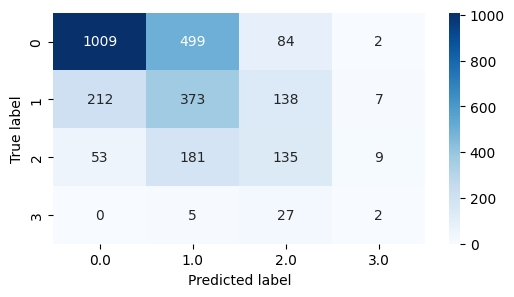

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(eda["sii"], eda["preds"])
plt.figure(figsize=(6, 3))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues", 
    xticklabels=eda["preds"].unique(), 
    yticklabels=eda["sii"].unique()
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()